## Projection of Raw Data on Spherical Surface

In [34]:
import os, csv, pickle, gzip, torch
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from scipy.spatial.transform import Rotation as R

#========= read =========================================================================
# features(ffile):   return [trimX, trimY, trimAnimTs, trimGTPos, trimHmdTs, trimHmd1Ts, trimEyeTs, self.l_trim_idx]
# sorted_params(sfile):  (row=subject) (column=file_num)
# df_files(dffile): (param df data for all subject, file pairs)
# 	sub_idx	file_idx	is_exclude	start_idx	end_idx	length	h	v	d	x	y	z
def read_gzip(path):    
    # All VERSIONs should match (pickle, python, pandas)
    output = []
    assert os.path.exists(path), 'ReadGzip Assertion: path is null: {0}'.format(path)
    with gzip.open(path, 'rb') as file:
        print("open gzip")
        output = pickle.load(file)     
    return output


spath = "data/data_feature/sorted-params.csv"
sfile = open(spath, 'r', encoding='utf-8')
sfile = list(csv.reader(sfile))

# ver2 file makes vector feature velocity to hold (t) and (t-1)value instead of simple subtraction that is useless
# file_name = "0919-f18r16ver2"
file_name = "1017-f18r16ver3"
fpath = "data/data_feature/" + file_name + ".gz"
ffile = read_gzip(fpath)

dfpath = "data/data_feature/0216-df.csv"
dffile = pd.read_csv(dfpath, na_values=" NaN").dropna(how='all', axis=1)
dffile = dffile[['sub_idx','file_idx','length', 'is_exclude', 'h','v','d','x','y','z']]
# print(dffile.head)

params_df = dffile[['h','v','d']]
params_tensor = torch.tensor(params_df.values, dtype=torch.float32)
PARAMS = params_tensor.reshape(24, 144, 3)
# print(PARAMS[0])


#=========== group ==================
#depth = (0.9, 1.7, 2.5, 3.3)
#angles = (+-30 azimuth, +-20 elevation)

# 2 5 8
# 1 4 7
# 0 3 6

#cross: 1,3,5,7
#center: 4
#oblique: 0,2,6,8



    
          

open gzip


C:\Users\motionlab_3080\AppData\Local\Temp\ipykernel_3508\154429882.py:82: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = 13 #further viewing distance to counter clipping
C:\Users\motionlab_3080\AppData\Local\Temp\ipykernel_3508\154429882.py:55: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = 13 #further viewing distance to counter clipping


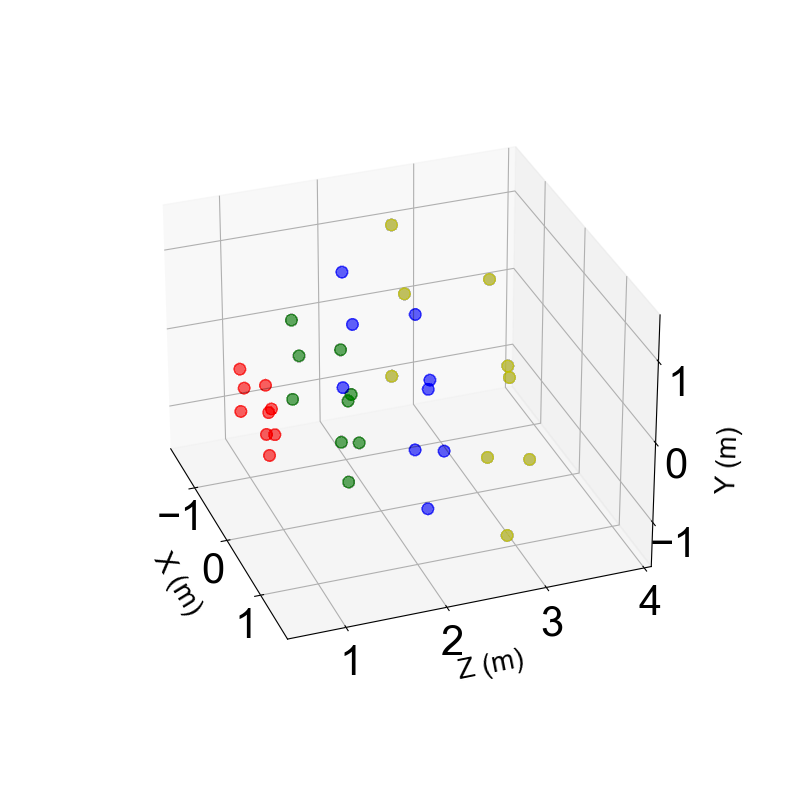

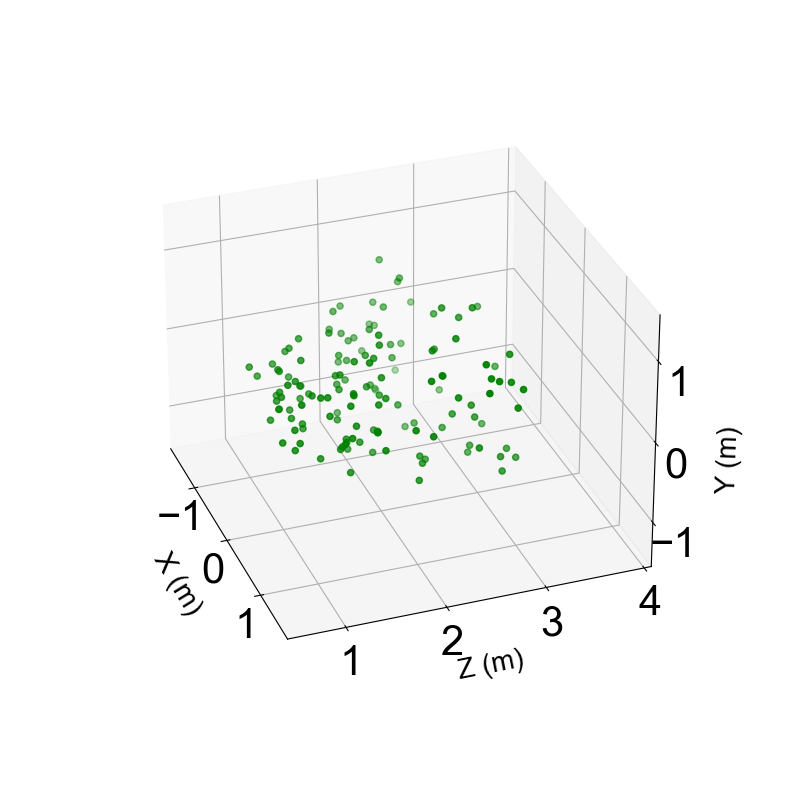

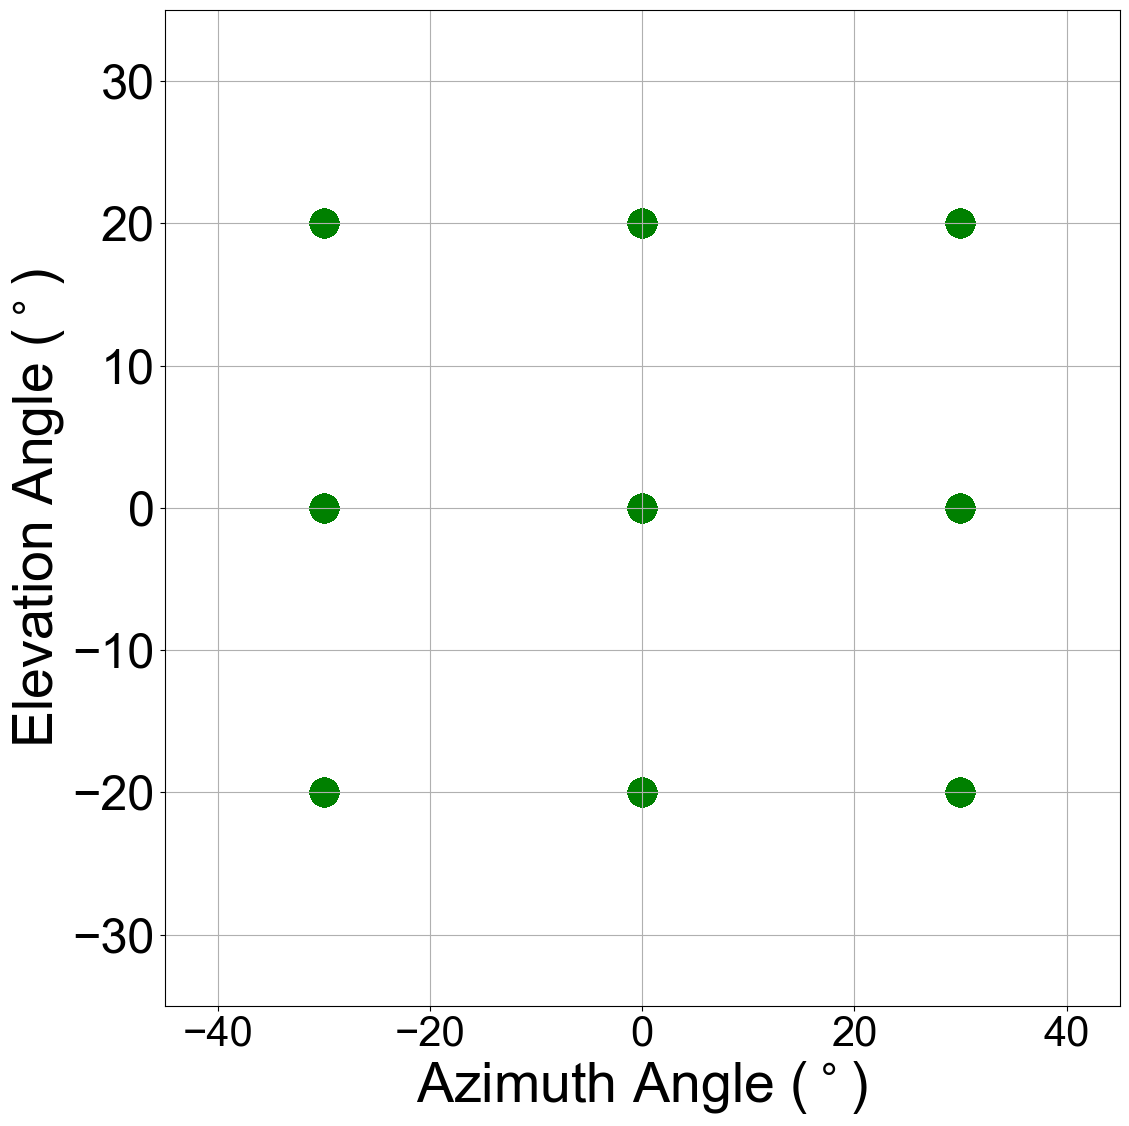

In [120]:
#========= proj functions =========================================================================

%matplotlib notebook
%matplotlib inline
from tqdm import tqdm
from functools import partial
from matplotlib.animation import FuncAnimation
from matplotlib.animation import PillowWriter
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
from matplotlib import rc
import matplotlib.cm as cm
from matplotlib.collections import LineCollection
import matplotlib
matplotlib.rcParams['font.family'] = "Arial"

def plot_gt_angles(dffile):
    #=================SET PLOT================================
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 12))
    # plt.suptitle("Projection on Spherical Visual Field", fontsize=18)
    matplotlib.rc('xtick', labelsize=35) 
    matplotlib.rc('ytick', labelsize=35)     
    fig.tight_layout(pad=5)
    
    data = dffile.loc[dffile.sub_idx <16]
    x = data.h
    y = data.v
    axes.set_xlim(-45,45)
    axes.set_ylim(-35,35)
    axes.set_xlabel('Azimuth Angle ($^\circ$)', fontsize=40)
    axes.set_ylabel('Elevation Angle ($^\circ$)', fontsize=40) 
    axes.scatter(x,y, s=400, c='g', label='ground truth')

    plt.grid()

    
    
    
def plot_targets(dffile, sub_idx, color):
    ax = plt.figure(figsize=(12,10)).add_subplot(projection='3d')
   
    data = dffile.loc[dffile.sub_idx == sub_idx]

    x = data.x
    y = data.y
    z = data.z
    ax.scatter(x, z, zs=y, zdir='z', c=color, label='targets')
    ax.set_xlim(-1.7, 1.7)
    ax.set_ylim(0.5, 4)
    ax.set_zlim(-1.5, 1.5)
    ax.set_xlabel('X (m)', fontsize=20, labelpad=20)     
    ax.set_ylabel('Z (m)', fontsize=20, labelpad=20)     
    ax.set_zlabel('Y (m)', fontsize=20, labelpad=20)     
    ax.view_init(elev=30, azim=-20, roll=0)
    ax.dist = 13 #further viewing distance to counter clipping

    
def plot_uniform_targets(dffile, sub_idx):
    ax = plt.figure(figsize=(12,10)).add_subplot(projection='3d')   
    data = dffile.loc[dffile.sub_idx == sub_idx]    

    
    depths = [0.9, 1.7, 2.5, 3.3]
    colors = ['r', 'g', 'b', 'y']
    for i, d in enumerate(depths):
        data = dffile.loc[dffile.sub_idx == sub_idx]
        data = dffile.loc[dffile.d == d]
        color = colors[i]
        x = data.x
        y = data.y
        z = data.z
        ax.scatter(x, z, zs=y, zdir='z', c=color, label='targets', s=70, alpha=0.01)
    
    
    ax.set_xlim(-1.7, 1.7)
    ax.set_ylim(0.5, 4)
    ax.set_zlim(-1.5, 1.5)    
    ax.set_xlabel('X (m)', fontsize=20, labelpad=20)     
    ax.set_ylabel('Z (m)', fontsize=20, labelpad=20)     
    ax.set_zlabel('Y (m)', fontsize=20, labelpad=20)     
    ax.view_init(elev=30, azim=-20, roll=0)
    ax.dist = 13 #further viewing distance to counter clipping    

matplotlib.rc('xtick', labelsize=30) 
plot_uniform_targets(dffile, 0)
plot_targets(dffile, 16, 'g')
plot_gt_angles(dffile)


# Seeing Exclusion values for each subjects

2226/2304 sequences were chosen. 78 sequences were discarded

In [2]:
count = 0
for sidx in range(16):
    scount = 0
    for fidx in range(144):
        row = dffile.loc[(dffile['sub_idx'] == sidx) & (dffile['file_idx'] ==fidx)]
        # print(exclude)
        exclude = row.is_exclude.item() #if .item() is not used we will access timeseries which makes error
        # print(exclude)
        if exclude == -1:
            scount += 1
            count += 1
            # print(sidx, fidx)
    print("subject count", sidx, scount, 144 - scount)
print("whole count", 144*16 - count, 144*16, count)

subject count 0 8 136
subject count 1 6 138
subject count 2 1 143
subject count 3 9 135
subject count 4 5 139
subject count 5 1 143
subject count 6 11 133
subject count 7 1 143
subject count 8 3 141
subject count 9 1 143
subject count 10 1 143
subject count 11 2 142
subject count 12 12 132
subject count 13 7 137
subject count 14 1 143
subject count 15 9 135
whole count 2226 2304 78


In [3]:
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms


def confidence_ellipse(x, y, ax, n_std=1.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """
    if x.shape != y.shape:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensional dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs, linewidth=1.5)

    # Calculating the standard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the standard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

In [4]:
#========= proj functions =========================================================================

%matplotlib notebook
%matplotlib inline
from tqdm import tqdm
from functools import partial
from matplotlib.animation import FuncAnimation
from matplotlib.animation import PillowWriter
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
from matplotlib import rc
import matplotlib.cm as cm
from matplotlib.collections import LineCollection
import matplotlib
matplotlib.rcParams['font.family'] = "Arial"


def calc_features_by_file(file_name, save_name, ffile, sfile, PARAMS):
    """
    ffile = feature file for subject
    sfile = pointer idx file
    PARAMS = parameter file for all sub sessions
    """
    gt_params, gt_poses=[],[]
    hrc_params, hrc_poses=[],[]
    eye_c_params, eye_c_poses=[],[]
    eye_l_params, eye_l_poses=[],[]
    eye_r_params, eye_r_poses=[],[]   
    
    for fIdx in tqdm(range(144)):        
        colors = cm.rainbow(np.linspace(0, 1, 24))

        gt_param, gt_pos=[],[]
        hrc_param, hrc_pos=[],[]
        eye_c_param, eye_c_pos=[],[]
        eye_l_param, eye_l_pos=[],[]
        eye_r_param, eye_r_pos=[],[]    
         
        for sIdx in range(1,16):
            pIdx = int(sfile[sIdx][fIdx]) #pointer idx
            excludeIdx = int()
            param = PARAMS[sIdx][pIdx]
            trimX,trimY,_,trimGTPos, trimHmd,trimHmd1,trimEye,trimEye1,_ = ffile[sIdx]
            # Hmd = [f,4]4], Eye = [f,3,4,4], Eye1 = [f,3,4,4] combin, left, right
            # all files 144
            #print(str(sIdx), " and file distance: ", param[2])
                        
            # ----trim to end Idx------------            
            end_idx = len(trimX[pIdx])-1
            trimHmd = trimHmd[pIdx][:end_idx+1]     #ts
            trimHmd1 = trimHmd1[pIdx][:end_idx+1]     #ts
            trimEye = trimEye[pIdx][:end_idx+1]
            trimEye1 = trimEye1[pIdx][:end_idx+1]
            trimGTPos =trimGTPos[pIdx][:end_idx+1]   #pos
            trimY = trimY[pIdx][:end_idx+1]         #rel_params

            # ----separate eye file------------     
            trimEye_c = trimEye[:, 0]  #comb eye
            trimEye1_c = trimEye1[:, 0] #comb eye
            trimEye_l = trimEye[:, 1]  #comb eye
            trimEye1_l = trimEye1[:, 1] #comb eye
            trimEye_r = trimEye[:, 2]  #comb eye
            trimEye1_r = trimEye1[:, 2] #comb eye            
            
            # ----downsample OR use only last frame------------     
#             trimHmd = trimHmd[::40]  
#             trimHmd1 = trimHmd1[::40]
#             trimEye = trimEye[::40]
#             trimEye1 = trimEye1[::40]   
#             trimGTPos =trimGTPos[::40]  
#             trimY = trimY[::40]          
            
            # ----make input tensor to 3dim---(e.g [f,4,4] or [1,4,4] for single frame)
            # pickframe = [-21] # -26, -16
            pickframe = np.array([-24,-23,-22,-21,-20,-19,-18]) #11 frames or +- 5 frames around least movement point
            # pickframe = np.array([-27,-26,-25,-24,-23,-22,-21,-20,-19,-18,-17,-16,-15]) #11 frames or +- 5 frames around least movement point
            FRAMES = len(pickframe)
            trimHmd = trimHmd[pickframe]
            trimHmd1 = trimHmd1[pickframe]
            
            trimEye_c = trimEye_c[pickframe]
            trimEye1_c = trimEye1_c[pickframe]
            
            trimEye_l = trimEye_l[pickframe]
            trimEye1_l = trimEye1_l[pickframe]
            
            trimEye_r = trimEye_r[pickframe]
            trimEye1_r = trimEye1_r[pickframe]     
            
            trimGTPos =trimGTPos[pickframe]
            trimY = trimY[pickframe]

            #----------calculate--------------------------------------
            # [f,4,4] -> [f,3] or f frames of positions.
            row = dffile.loc[(dffile['sub_idx'] == sIdx) & (dffile['file_idx'] ==fIdx)]
            if row.is_exclude.item()  == -1: # fill dummy values for null  NA array.
                pos_gt = torch.full((FRAMES, 3), -torch.inf)
                pos_hrc = torch.full((FRAMES, 3), -torch.inf)
                pos_eye_c = torch.full((FRAMES, 3), -torch.inf)
                pos_eye_l = torch.full((FRAMES, 3), -torch.inf)
                pos_eye_r = torch.full((FRAMES, 3), -torch.inf)
                # print("exclusion item")
            else:
                pos_gt = hmd_pos_to_hmd1_pos(trimGTPos, trimHmd1)      
                pos_hrc = calc_hrc(trimHmd, trimHmd1, param) # 
                pos_eye_c = calc_erc(trimHmd, trimHmd1, trimEye_c, trimEye1_c, param)
                pos_eye_l = calc_erc(trimHmd, trimHmd1, trimEye_l, trimEye1_l, param)
                pos_eye_r = calc_erc(trimHmd, trimHmd1, trimEye_r, trimEye1_r, param)

            #-----------TO ANGLE----------------
            #[1,3] per (file, subject) pair
            param_gt = pos_to_param(pos_gt)
            param_hrc = pos_to_param(pos_hrc)
            param_eye_c = pos_to_param(pos_eye_c)
            param_eye_l = pos_to_param(pos_eye_l)
            param_eye_r = pos_to_param(pos_eye_r)
            
            #------------To one array tensor---------
            param_gt = param_gt.reshape(len(pickframe), 3)
            param_hrc = param_hrc.reshape(len(pickframe), 3)
            param_eye_c =param_eye_c.reshape(len(pickframe), 3)
            param_eye_l = param_eye_l.reshape(len(pickframe), 3)
            param_eye_r =  param_eye_r.reshape(len(pickframe), 3)
            
            #-----------append----------------
            gt_param.append(param_gt)
            hrc_param.append(param_hrc)
            eye_c_param.append(param_eye_c)
            eye_l_param.append(param_eye_l)
            eye_r_param.append(param_eye_r)       
            
            gt_pos.append(pos_gt)
            hrc_pos.append(pos_hrc)
            eye_c_pos.append(pos_eye_c)
            eye_l_pos.append(pos_eye_l)
            eye_r_pos.append(pos_eye_r)
                        
        gt_params.append(gt_param)
        hrc_params.append(hrc_param)
        eye_c_params.append(eye_c_param)
        eye_l_params.append(eye_l_param)
        eye_r_params.append(eye_r_param)         
        
        gt_poses.append(gt_pos)
        hrc_poses.append(hrc_pos)
        eye_c_poses.append(eye_c_pos)
        eye_l_poses.append(eye_l_pos)
        eye_r_poses.append(eye_r_pos)    
    
    #===========return dictionary===========
    data_param = {'gt':gt_params, 'hrc':hrc_params, 'eye_c':eye_c_params, 'eye_l':eye_l_params, 'eye_r':eye_r_params, 'FRAMES':FRAMES}
    data_pos = {'gt':gt_poses, 'hrc':hrc_poses, 'eye_c':eye_c_poses, 'eye_l':eye_l_poses, 'eye_r':eye_r_poses, 'FRAMES':FRAMES}
    
    #============save dict==================
    with open('projraw_params.pickle', 'wb') as handle:
        pickle.dump(data_param, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    with open('projraw_poses.pickle', 'wb') as handle:
        pickle.dump(data_pos, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    return data_param, data_pos


#============================================================
def pos_to_param(input):   
    '''
    input: true spherical position
    output: true rectilinear param
    ''' 
    l_output = []
    for idx, pos in enumerate(input):
        x, y, z = pos[0], pos[1], pos[2]
        hor = np.arctan(-x/z) * 180 / np.pi
        ver = np.arctan(y/z) * 180 / np.pi
        dist = np.sqrt(x*x + y*y + z*z)
        param = torch.tensor([hor, ver, dist], dtype=torch.float32)
        l_output.append(param)
    l_output = torch.stack(l_output)
    return l_output     


def param_to_pos(input):
    """
    input: true param [F] X [params]
    output: spherical position
    """
    l_output = []
    for idx, param in enumerate(input):
        h, v, d = param[0], param[1], param[2]
        H = h * np.pi / 180
        V = v * np.pi / 180
        x = -(d) * np.sin(H) * np.cos(V)
        y = (d) * np.cos(H) * np.sin(V) # ours attenuate y with cosH    
        z = (d) * np.cos(H) * np.cos(V)
        pos = torch.tensor([x,y,z], dtype=torch.float32)
        if isUnity:
            x *=-1
        if isIncludeIdx:
            pos = np.array([idx+1, x, y, z], dtype=np.float64)
            header = 'index, x, y, z'
        else:
            pos = np.array([x, y, z], dtype=np.float64)
            header = 'x, y, z'
        l_output.append(pos)    
    l_output = torch.stack(l_output)
    return l_output

def hmd_pos_to_hmd1_pos(GTPos, hmd_1st_tensor): # GT POS
    '''
    >TRUE SPHERICAL Y SETUP, UNITY -X SETUP
    TENSOR LIST FOR SINGLE FRAME SEQ
    input: e.g.[2200, 3], [2200, 4, 4]
    return: e.g. [2200, 3]
    '''
    l_output= []
    for frame, (gt_pos, hmd_1st) in enumerate(zip(GTPos, hmd_1st_tensor)):
        t_op = torch.eye(4)
        x,y,z = gt_pos[0], gt_pos[1], gt_pos[2]
        t_op[:3, 3] = torch.tensor([x,y,z], dtype=torch.float32)
        t_oh = hmd_1st 
        # t_hp = t_ho * t_op = inv(t_oh) * t_op
        t = torch.matmul(torch.linalg.inv(t_oh), t_op)
        l_output.append(t[:3, 3])
    l_output = torch.stack(l_output)

    return l_output

def calc_hrc(hmd, hmd1, param):
    hrc_proj_pos_tensors = []
    azimuth, elevation, distance = param    
    for f, (t_h, t_h1) in enumerate(zip(hmd, hmd1)):    
        t_h1h = torch.matmul(torch.linalg.inv(t_h1), t_h)
        d1 = torch.norm(t_h1h[:3,3])
        d2 = torch.sqrt(distance*distance - d1*d1)
        t_hd2 = torch.eye(4,4)
        t_hd2[2,3] = d2
        t_h1d2 = torch.matmul(t_h1h, t_hd2)
        hrc_proj_pos_tensors.append(t_h1d2[:3,3])
    hrc_proj_pos_tensors = torch.stack(hrc_proj_pos_tensors)
    return hrc_proj_pos_tensors


def calc_erc(hmd, hmd1, eye, eye1, param):
    erc_proj_pos_tensors = []
    azimuth, elevation, distance = param    
    for f, (t_h, t_h1, t_he, t_he1) in enumerate(zip(hmd, hmd1, eye, eye1)):    
        t_h1h = torch.matmul(torch.linalg.inv(t_h1), t_h)
        t_h1e = torch.matmul(t_h1h, t_he)

        d1 = torch.norm(t_h1h[:3,3])
        d2 = torch.sqrt(distance*distance - d1*d1)
        d3 = torch.norm(t_he[:3,3])
        d4 = torch.sqrt(d2*d2 - d3*d3)

        t_ed4 = torch.eye(4,4)
        t_ed4[2,3] = d4
        t_h1d4 = torch.matmul(t_h1e, t_ed4)
        erc_proj_pos_tensors.append(t_h1d4[:3,3])
    erc_proj_pos_tensors = torch.stack(erc_proj_pos_tensors)
    return erc_proj_pos_tensors




data_params, data_poses = calc_features_by_file(file_name, "testtest", ffile, sfile, PARAMS)

100%|████████████████████████████████████████████████████████████████████████████████| 144/144 [00:24<00:00,  5.97it/s]


torch.Size([144, 15, 7, 3]) torch.Size([144, 15, 7, 3]) torch.Size([144, 15, 7, 3])


C:\Users\motionlab_3080\AppData\Local\Temp\ipykernel_14120\644963745.py:85: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  new_indices =torch.tensor(new_indices, dtype=torch.int32)


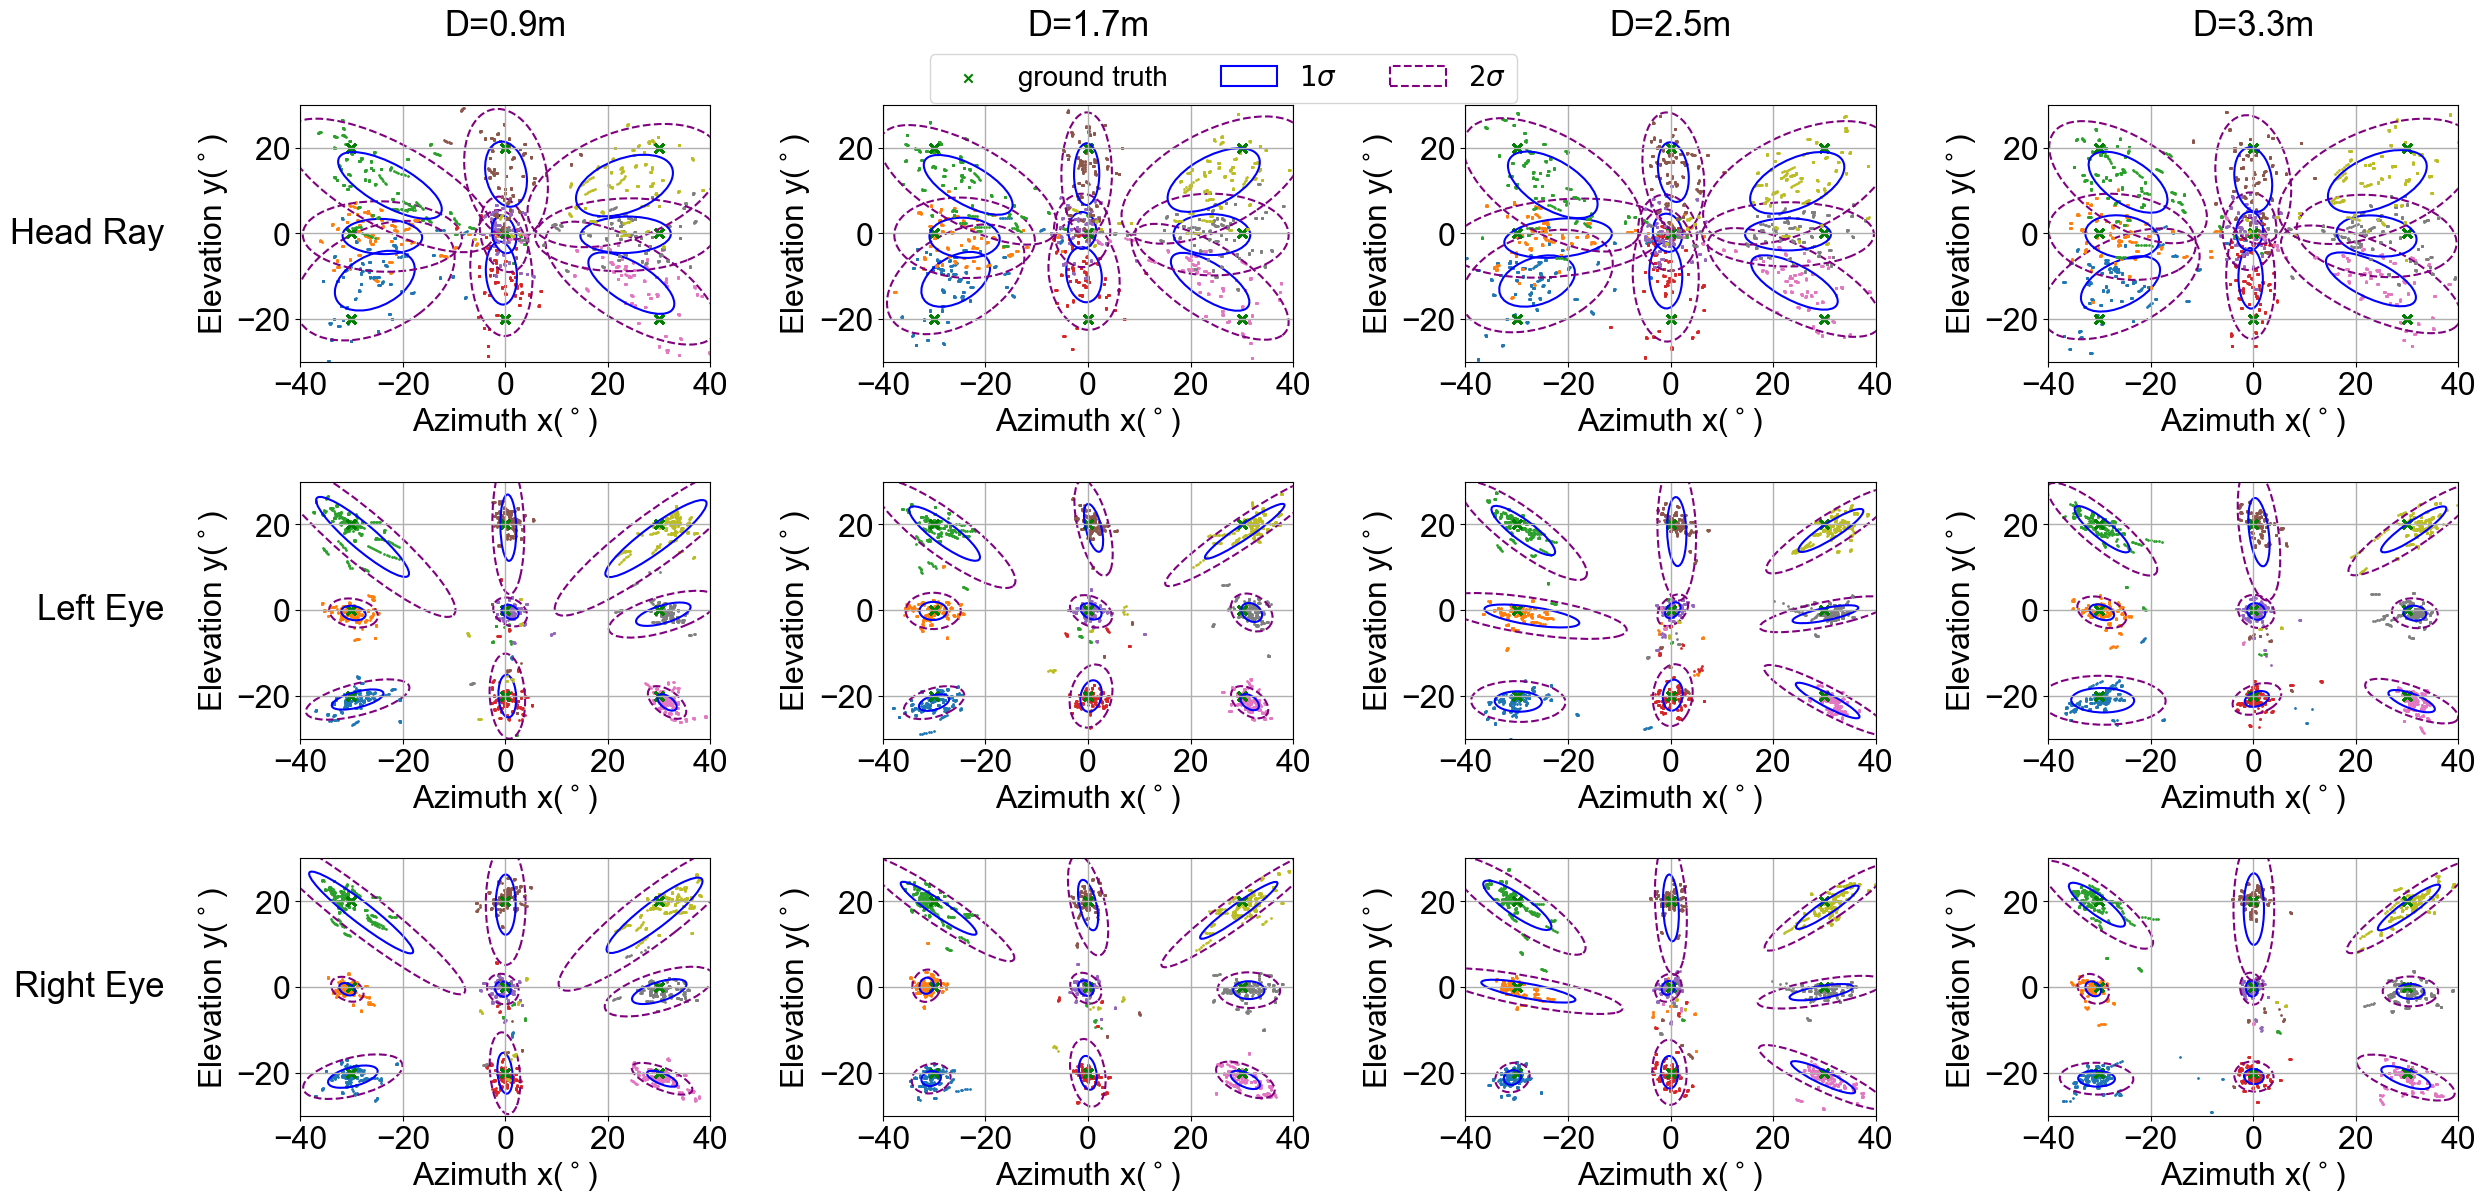

In [7]:
# draw_features_by_file(file_name, save_name, ffile, sfile)
#====================================================================
def draw_plot(data):
    """
    144 files, 15 subjects
    data: "data_params" from calc_features_by_file :
        >HRC[144][15][f,3], Eye_c[144][15][f,3], Eye_l[144][15][f,3], Eye_r[144][15][f,3]
    func: draw accuracy(mean) & precision(bvea) plot for depths
    """
    #=================SET PLOT================================
    fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(24, 12))
    # plt.suptitle("Projection on Spherical Visual Field", fontsize=18)
    matplotlib.rc('xtick', labelsize=23) 
    matplotlib.rc('ytick', labelsize=23)     
    fig.tight_layout(pad=5)

    col_names = ['{}'.format(col) for col in ['D=0.9m','D=1.7m','D=2.5m','D=3.3m']]
    row_names = ['{}'.format(row) for row in ['Head Ray', 'Left Eye', 'Right Eye']]
    plt.setp(axes.flat, xlabel='X-label', ylabel='Y-label')
    col_pad = 50 # in points
    row_pad = 20
    
    for ax, col in zip(axes[0], col_names):
        ax.annotate(col, xy=(0.5, 1), xytext=(0, col_pad),
                    xycoords='axes fraction', textcoords='offset points',
                    size=25, ha='center', va='baseline')

    for ax, row in zip(axes[:,0], row_names):
        ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - row_pad, 0),
                    xycoords=ax.yaxis.label, textcoords='offset points',
                    size=25, ha='right', va='center')

    for idx, ax in np.ndenumerate(axes):
        ax.set_xlabel('Azimuth x($^\circ$)', fontsize=23)
        ax.set_ylabel('Elevation y($^\circ$)', fontsize=23)
        ax.set_xlim(-40,40)
        # ax.set_xlim(-2,2)
        ax.set_ylim(-30,30)
        # ax.set_ylim(-1.5,1.5)
        ax.locator_params(nbins=5, axis='x') #xtick density

    #=================CONFIGURE DATA================================ 
    '''
    gt: list[144][15]tensor[f, 3] of params
    hrc: list[144][15]tensor[f, 3] of params
    eye_c: list[144][15]tensor[f, 3] of params
    eye_l: list[144][15]tensor[f, 3] of params
    eye_r: list[144][15]tensor[f, 3] of params
    FRAMES: f
    '''
    gt = data['gt']
    hrc = data['hrc']
    eye_c = data['eye_c']
    eye_l = data['eye_l']
    eye_r = data['eye_r']
    FRAMES = data['FRAMES']

    #====================FILL DATA==================================
    # format to tensor [144,15,3]
    gt_tensor = torch.empty((144, 15, FRAMES, 3))
    hrc_tensor = torch.empty((144, 15, FRAMES, 3))
    eye_l_tensor = torch.empty((144, 15, FRAMES, 3))
    eye_r_tensor = torch.empty((144, 15, FRAMES, 3))
    for fidx in range(144):
        for sidx in range(15):
            gt_tensor[fidx][sidx] = gt[fidx][sidx].reshape(FRAMES,3)
            hrc_tensor[fidx][sidx] = hrc[fidx][sidx].reshape(FRAMES,3)
            eye_l_tensor[fidx][sidx] = eye_l[fidx][sidx].reshape(FRAMES,3)
            eye_r_tensor[fidx][sidx] = eye_r[fidx][sidx].reshape(FRAMES,3)
    print(gt_tensor.shape, hrc_tensor.shape, eye_l_tensor.shape)
    
    
    #====================REPETITION INDEX ORDERING==================================
    """
    FUNC: for each depth, 9angles*4repetitions => realign to (4, 4, 4, 4, 4, 4, 4, 4, 4)
    FUNC: Make new_indices
    """
    #[144,15,FRAMES,3] file to [4-depth, 9-target, 64-repet, FRAMES, 3] files
    new_indices = torch.empty(36)
    for fidx in range(36): #4 repetition
        remainder = fidx // 4
        floor = fidx % 4
        pointer_idx = floor * 9 + remainder
        new_indices[fidx]=pointer_idx
    new_indices =torch.tensor(new_indices, dtype=torch.int32)
    
    
    #====================ALIGN WITH NEW INDICES==================================
    """
    FUNC: reshape raw to (4depth, 36tries, 15subjects, Frames, 3pos)
    FUNC: Apply new indices to raw so that we can iterate for x,y angle coordinates
    FUNC: to (4depth, 9angles, 15subject*4trials, FRAMES, 3)
    """
    # pre-reshape => align target numbering => finish reshape
    gt_tensor = torch.reshape(gt_tensor, (4,36,15,FRAMES,3))    
    hrc_tensor = torch.reshape(hrc_tensor, (4,36,15,FRAMES,3))
    eye_l_tensor = torch.reshape(eye_l_tensor, (4,36,15,FRAMES,3))
    eye_r_tensor = torch.reshape(eye_r_tensor, (4,36,15,FRAMES,3))    
    gt_tensor = gt_tensor[:, new_indices] 
    hrc_tensor = hrc_tensor[:, new_indices] 
    eye_l_tensor = eye_l_tensor[:, new_indices] 
    eye_r_tensor = eye_r_tensor[:, new_indices]      
    gt_tensor = torch.reshape(gt_tensor, (4,9,60,FRAMES,3))   
    hrc_tensor = torch.reshape(hrc_tensor, (4,9,60,FRAMES,3))
    eye_l_tensor = torch.reshape(eye_l_tensor, (4,9,60,FRAMES,3))
    eye_r_tensor = torch.reshape(eye_r_tensor, (4,9,60,FRAMES,3))   
    
    #====================PLOT DATA==================================
    for didx, (ax, gt, data) in enumerate(zip(axes[0], gt_tensor, hrc_tensor)):   #iterate for depth     
        for pidx in range(9): #iterate for angle
            x_gt = np.array(gt[pidx, :, :, 0])
            y_gt = np.array(gt[pidx, :, :, 1])
            x=np.array(data[pidx, :, :, 0])
            y=np.array(data[pidx, :, :, 1])
            
            #[64,FRAMES]=>[64*FRAMES]
            x = x.reshape(-1)
            y = y.reshape(-1)
            x = x[np.isfinite(x)]
            y = y[np.isfinite(y)]
            
            ax.grid(linewidth=1)
            ax.scatter(x, y, s=1)             
            ax.scatter(x_gt, y_gt, c='g', marker='x', label='ground truth')          
            confidence_ellipse(x, y, ax, label=r'$1\sigma$', n_std=1, edgecolor='blue') 
            confidence_ellipse(x, y, ax, label=r'$2\sigma$', n_std=2, edgecolor='purple', linestyle='--')
            if didx ==0 and pidx ==0:
                ax.legend(bbox_to_anchor=(1.5, 0.95, 1.5, .3), ncol=3, loc='upper center', mode="expand", fontsize='20')
        
        
    for ax, data in zip(axes[1], eye_l_tensor):
        for pidx in range(9):
            x_gt = np.array(gt[pidx, :, :, 0])
            y_gt = np.array(gt[pidx, :, :, 1])
            x=np.array(data[pidx, :, :, 0])
            y=np.array(data[pidx, :, :, 1])
            
            #[64,FRAMES]=>[64*FRAMES]
            x = x.reshape(-1)
            y = y.reshape(-1)
            x = x[np.isfinite(x)]
            y = y[np.isfinite(y)]
            
            ax.grid(linewidth=1)
            ax.scatter(x, y, s=1)    
            ax.scatter(x_gt, y_gt, c='g', marker='x', label='ground truth')                          
            confidence_ellipse(x, y, ax, label=r'$1\sigma$', n_std=1, edgecolor='blue') 
            confidence_ellipse(x, y, ax, label=r'$2\sigma$', n_std=2, edgecolor='purple', linestyle='--')
     
    for ax, data in zip(axes[2], eye_r_tensor): 
        for pidx in range(9):    
            x_gt = np.array(gt[pidx, :, :, 0])
            y_gt = np.array(gt[pidx, :, :, 1])
            x=np.array(data[pidx, :, :, 0])
            y=np.array(data[pidx, :, :, 1])

            #[64,FRAMES]=>[64*FRAMES]
            x = x.reshape(-1)
            y = y.reshape(-1)
            x = x[np.isfinite(x)]
            y = y[np.isfinite(y)]            

            ax.grid(linewidth=1)
            ax.scatter(x, y, s=1)                 
            ax.scatter(x_gt, y_gt, c='g', marker='x', label='ground truth')                    
            confidence_ellipse(x, y, ax, label=r'$1\sigma$', n_std=1, edgecolor='blue') 
            confidence_ellipse(x, y, ax, label=r'$2\sigma$', n_std=2, edgecolor='purple', linestyle='--')
    
#     plt.show()

draw_plot(data_params)

# Calculate Angle Deviations from GT angle value (single value, or x,y, values)

- calculate angular deviation for each projection and store them as df
- label as {'target_idx'} for four depths
- can calculate MSTD of deviation angles
- can do normality test
- can do variance test
- can do one-way ANOVA

In [98]:
def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def degrees_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return (180 * np.arccos(np.dot(v1_u, v2_u))) / np.pi


def calcualte_deviances(data_poses):
    """
    INPUT:data_pos = {'gt':gt_poses, 'hrc':hrc_poses, 'eye_c':eye_c_poses, 'eye_l':eye_l_poses, 'eye_r':eye_r_poses, 'FRAMES':FRAMES}
    1.align data with target indices (4,9,60,FRAMES,3) for each feature
    2.reshape each feature to (4depth, 9angles, 60*FRAMES, 3)
    3.average to (4depth, 9angles, 3 coordinates) for GT, HEAD, EYE1,2
    4.transform from (param) -> (pos)
    5.calculate angle_between (GT-HEAD) (GT-EYE1,2)
    6.store or return as df
    """
        #=================CONFIGURE DATA================================ 
    '''
    gt: list[144][15]tensor[f, 3] of params
    hrc: list[144][15]tensor[f, 3] of params
    eye_c: list[144][15]tensor[f, 3] of params
    eye_l: list[144][15]tensor[f, 3] of params
    eye_r: list[144][15]tensor[f, 3] of params
    FRAMES: f
    '''
    gt = data_poses['gt']
    hrc = data_poses['hrc']
    eye_c = data_poses['eye_c']
    eye_l = data_poses['eye_l']
    eye_r = data_poses['eye_r']
    FRAMES = data_poses['FRAMES']

    #====================FILL DATA==================================
    # format to tensor [144,15,3]
    gt_tensor = torch.empty((144, 15, FRAMES, 3))
    hrc_tensor = torch.empty((144, 15, FRAMES, 3))
    eye_l_tensor = torch.empty((144, 15, FRAMES, 3))
    eye_r_tensor = torch.empty((144, 15, FRAMES, 3))
    for fidx in range(144):
        for sidx in range(15):
            gt_tensor[fidx][sidx] = gt[fidx][sidx].reshape(FRAMES,3)
            hrc_tensor[fidx][sidx] = hrc[fidx][sidx].reshape(FRAMES,3)
            eye_l_tensor[fidx][sidx] = eye_l[fidx][sidx].reshape(FRAMES,3)
            eye_r_tensor[fidx][sidx] = eye_r[fidx][sidx].reshape(FRAMES,3)
    print(gt_tensor.shape, hrc_tensor.shape, eye_l_tensor.shape)
    
    #====================REPETITION INDEX ORDERING==================================
    """
    FUNC: for each depth, 9angles*4repetitions => realign to (4, 4, 4, 4, 4, 4, 4, 4, 4)
    """
    #[144,15,FRAMES,3] file to [4-depth, 9-target, 64-repet, FRAMES, 3] files
    new_indices = torch.empty(36)
    for fidx in range(36): #4 repetition
        remainder = fidx // 4
        floor = fidx % 4
        pointer_idx = floor * 9 + remainder
        new_indices[fidx]=pointer_idx
    new_indices =torch.tensor(new_indices, dtype=torch.int32)
    
    #====================ALIGN WITH NEW INDICES==================================
    """
    FUNC: reshape raw to (4depth, 36tries, 15subjects, Frames, 3pos)
    FUNC: Apply new indices to raw so that we can iterate for x,y angle coordinates
    FUNC: to (4depth, 9angles, 15subject*4trials, FRAMES, 3)
    """
    # pre-reshape => align target numbering => finish reshape
    gt_tensor = torch.reshape(gt_tensor, (4,36,15,FRAMES,3))    
    hrc_tensor = torch.reshape(hrc_tensor, (4,36,15,FRAMES,3))
    eye_l_tensor = torch.reshape(eye_l_tensor, (4,36,15,FRAMES,3))
    eye_r_tensor = torch.reshape(eye_r_tensor, (4,36,15,FRAMES,3))    
    gt_tensor = gt_tensor[:, new_indices] 
    hrc_tensor = hrc_tensor[:, new_indices] 
    eye_l_tensor = eye_l_tensor[:, new_indices] 
    eye_r_tensor = eye_r_tensor[:, new_indices]      
    gt_tensor = torch.reshape(gt_tensor, (4,9,60,FRAMES,3))   
    hrc_tensor = torch.reshape(hrc_tensor, (4,9,60,FRAMES,3))
    eye_l_tensor = torch.reshape(eye_l_tensor, (4,9,60,FRAMES,3))
    eye_r_tensor = torch.reshape(eye_r_tensor, (4,9,60,FRAMES,3))   
    
    #2.reshape each feature to (4depth, 9angles, 60*FRAMES, 3)
    # inf values here pose problems...........
    gt_tensor = torch.reshape(gt_tensor, (4,9,60*FRAMES,3))   
    hrc_tensor = torch.reshape(hrc_tensor, (4,9,60*FRAMES,3))
    eye_l_tensor = torch.reshape(eye_l_tensor, (4,9,60*FRAMES,3))
    eye_r_tensor = torch.reshape(eye_r_tensor, (4,9,60*FRAMES,3))   
    gt_mask = gt_tensor != -torch.inf
    hrc_mask = hrc_tensor != -torch.inf    
    eye_l_mask = eye_l_tensor != -torch.inf    
    eye_r_mask = eye_r_tensor != -torch.inf    
    
    #3.average to (4depth, 9angles, 3 coordinates) for GT, HEAD, EYE1,2 [4d, 9a, 3coords]
    gt_tensor = torch.nanmean(gt_tensor*gt_mask, axis=2)
    hrc_tensor = torch.nanmean(hrc_tensor*hrc_mask, axis=2)
    eye_l_tensor = torch.nanmean(eye_l_tensor*eye_l_mask, axis=2)
    eye_r_tensor = torch.nanmean(eye_r_tensor*eye_r_mask, axis=2)
    
    #4.calculate angle_between (GT-HEAD) (GT-EYE1,2) [4d, 9a, 3coords] --dataframe--> [4row, 9col]dataframe
    data_head = []
    data_eyel = []
    data_eyer = []
    for didx in range(4):
        data_head_angles=[]
        data_eyel_angles=[]
        data_eyer_angles=[]
        for aidx in range(9):
            data_head_angles.append(degrees_between(gt_tensor[didx][aidx], hrc_tensor[didx][aidx]))
            data_eyel_angles.append(degrees_between(gt_tensor[didx][aidx], eye_l_tensor[didx][aidx]))
            data_eyer_angles.append(degrees_between(gt_tensor[didx][aidx], eye_r_tensor[didx][aidx]))                 
        data_head.append(data_head_angles)
        data_eyel.append(data_eyel_angles)
        data_eyer.append(data_eyer_angles)
    df_head = pd.DataFrame(data_head)
    df_eyel = pd.DataFrame(data_eyel)
    df_eyer = pd.DataFrame(data_eyer)
    #6.store or return as df
    
    return df_head, df_eyel, df_eyer




# def analysis_on_df(df_array):
#     """
#     INPUT = [df_head, df_eyel, df_eyer] where each df has ["depth","angle","deviance"<-(in degrees)]
#     1.perform normality check
#     2.perform variance check
#     3.perform anova
#     4.perform MSTD
#     """
    
    


In [99]:
"""
data_param = {'gt':gt_params, 'hrc':hrc_params, 'eye_c':eye_c_params, 'eye_l':eye_l_params, 'eye_r':eye_r_params, 'FRAMES':FRAMES}
data_pos = {'gt':gt_poses, 'hrc':hrc_poses, 'eye_c':eye_c_poses, 'eye_l':eye_l_poses, 'eye_r':eye_r_poses, 'FRAMES':FRAMES}
"""
# data_params, data_poses = calc_features_by_file(file_name, "testtest", ffile, sfile, PARAMS)
df_head, df_eyel,df_eyer = calcualte_deviances(data_poses)
print(df_head)
print(df_eyel)
print(df_eyer)


torch.Size([144, 15, 7, 3]) torch.Size([144, 15, 7, 3]) torch.Size([144, 15, 7, 3])
          0         1          2          3         4         5          6  \
0  8.694070  6.012946  10.263605  10.623935  0.431601  6.722108   9.015501   
1  8.850840  5.401129   9.600829  10.398241  0.907844  6.899499   9.621570   
2  8.222897  7.938648  10.336622  10.375663  0.275536  5.446401   9.157703   
3  8.123446  4.580907   9.314729   9.920001  0.404452  7.850830  10.953139   

          7         8  
0  5.800019  9.450972  
1  6.467326  8.411812  
2  7.055967  9.159419  
3  6.538370  9.929473  
          0         1         2         3         4         5         6  \
0  1.950236  1.012011  3.858082  0.873125  1.308956  1.966923  1.434496   
1  1.400256  0.703043  2.869217  1.038728  0.860256  1.767908  1.394514   
2  1.451043  4.004724  2.531805  0.846035  0.694925  2.160392  0.782847   
3  2.089285  1.068262  1.828527  1.138664  0.929780  2.931312  1.218686   

          7         8  
0  1.

C:\Users\motionlab_3080\AppData\Local\Temp\ipykernel_14120\3200450575.py:71: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  new_indices =torch.tensor(new_indices, dtype=torch.int32)


### 3. Normality Test, Variance Test for all stuff

In [125]:
# whole mean, std
print("head_proj", round(df_head.mean().mean(),2), round(df_head.stack().std(),2) )
print("eyel_proj", round(df_eyel.mean().mean(),2), round(df_eyel.stack().std(),2) )
print("eyer_proj", round(df_eyer.mean().mean(),2), round(df_eyer.stack().std(),2) )


#axis = 0: for each angle
# print(round(df_head.mean(axis=0),2), round(df_head.std(axis=0),2))
# print(round(df_eyel.mean(axis=0),2), round(df_eyel.std(axis=0),2))
# print(round(df_eyer.mean(axis=0),2), round(df_eyer.std(axis=0),2))

#axis = 1: for each depth
print(round(df_head.mean(axis=1),2), round(df_head.std(axis=1),2))
print(round(df_eyel.mean(axis=1),2), round(df_eyel.std(axis=1),2))
print(round(df_eyer.mean(axis=1),2), round(df_eyer.std(axis=1),2))

head_proj 7.48 3.01
eyel_proj 1.68 0.84
eyer_proj 1.34 0.71
0    7.45
1    7.40
2    7.55
3    7.51
dtype: float64 0    3.17
1    2.94
2    3.14
3    3.30
dtype: float64
0    1.82
1    1.51
2    1.72
3    1.65
dtype: float64 0    0.99
1    0.65
2    1.10
3    0.64
dtype: float64
0    1.47
1    1.27
2    1.37
3    1.25
dtype: float64 0    0.98
1    0.61
2    0.66
3    0.63
dtype: float64


# normality check

In [161]:
import math
import numpy as np
import scipy
from scipy.stats import shapiro 
from scipy.stats import kstest
from scipy.stats import lognorm
import scipy.stats as stats
import seaborn as sns
from scipy.stats import f_oneway
print("for all data") # 1 group? 
print( shapiro( df_head.stack() ) )
print( shapiro(df_eyel.stack() ) )
print( shapiro(df_eyer.stack() ) )
print( shapiro( scipy.stats.lognorm.fit(df_head.stack())) )
print( shapiro( scipy.stats.lognorm.fit(df_eyel.stack())) )
print( shapiro( scipy.stats.lognorm.fit(df_eyer.stack())) )

# CANNOT GO ON ANY FURTHER. Applying log to skewed data changes characteristics of the data, and is not recommended

for all data
ShapiroResult(statistic=0.8457320332527161, pvalue=0.0001520354999229312)
ShapiroResult(statistic=0.8904238343238831, pvalue=0.0018866091268137097)
ShapiroResult(statistic=0.8343794941902161, pvalue=8.485941361868754e-05)
ShapiroResult(statistic=1.0, pvalue=1.0)
ShapiroResult(statistic=0.985494077205658, pvalue=0.7694157381316403)
ShapiroResult(statistic=0.7930178642272949, pvalue=0.09793655372742693)


In [228]:
print("for each angle") # N = 9 groups

head_gp = df_head.mean(axis=0)
eyel_gp = df_eyel.mean(axis=0)
eyer_gp =df_eyer.mean(axis=0)
print( shapiro( head_gp ) )
print( shapiro( eyel_gp ) )
print( shapiro( eyer_gp ) )
print(df_head)



for i in range(3):
    for j in range(3):
        


#=========================================



#===========horizontal====================
h_left = [0,1,2]
h_center = [3,4,5]
h_right = [6,7,8]


#===========cross/x====================
cross = [1,3,5,7]
x = [0,2,6,8]

# print(head_gp)
# # Levene 검정은 표본이 정규성을 만족하든 만족하지 않든 상관없이 사용할 수 있다.
# print(stats.levene( *head_values))  # very small--(x)
# print(stats.levene( *eyel_values)) # 0.16 ----------> 통과



# print(stats.bartlett(*[[x] for x in head_gp] )) # veryvery small (x)
# print(stats.bartlett( *[[x] for x in head_gp] ))# too small (x)
# print(stats.bartlett( *[[x] for x in head_gp] ))# too small (x)


for each angle
ShapiroResult(statistic=0.833714485168457, pvalue=0.04914455860853195)
ShapiroResult(statistic=0.9324601888656616, pvalue=0.5051191449165344)
ShapiroResult(statistic=0.9300681948661804, pvalue=0.4819958209991455)
          0         1          2          3         4         5          6  \
0  8.694070  6.012946  10.263605  10.623935  0.431601  6.722108   9.015501   
1  8.850840  5.401129   9.600829  10.398241  0.907844  6.899499   9.621570   
2  8.222897  7.938648  10.336622  10.375663  0.275536  5.446401   9.157703   
3  8.123446  4.580907   9.314729   9.920001  0.404452  7.850830  10.953139   

          7         8  
0  5.800019  9.450972  
1  6.467326  8.411812  
2  7.055967  9.159419  
3  6.538370  9.929473  


AttributeError: 'Series' object has no attribute 'assign'

In [212]:
print("for each depth") # N = 4 groups

head_gp = df_head.mean(axis=1).tolist()
eyel_gp = df_eyel.mean(axis=1).tolist()
eyer_gp =df_eyer.mean(axis=1).tolist()

print( shapiro( head_gp ) )
print( shapiro( eyel_gp ) )
print( shapiro( eyer_gp ) )


head_list = [(x) for x in head_gp]
print(*head_list)




print(f_oneway( head_gp[0], head_gp[1], head_gp[2], head_gp[3] ) )


for each depth
ShapiroResult(statistic=0.9707746505737305, pvalue=0.8462748527526855)
ShapiroResult(statistic=0.9916262626647949, pvalue=0.9656479954719543)
ShapiroResult(statistic=0.9261007905006409, pvalue=0.5716757774353027)
7.44608390787559 7.395454345062537 7.552095217658015 7.512816296809643


ValueError: zero-dimensional arrays cannot be concatenated